# NBA Research

The NBA style of play has changed dramatically since the birth of the league. 

In the 1950s and 1960s, teams played at a frenetic pace, relying very heavily on their star players, some logging a season average of over 48 minutes.

...

Moden playing styles rely heavily on high quality shots - free throws, layups and 3 pointers, and we are seeing teams rely more heavily on depth (the days of superstar players logging over 40 minutes are gone).

The role of the modern day point guard has also shifted immensely, taking on more responsibility to score and shoot the ball, seen less as a floor general. However, since the level of skill in the modern day NBA has increased greatly (emergence of the point forward, flow of talent from Europe and focus on developing shooting and dribbling skills), teams can rely on other positions to create scoring opportunities.

With game-level data for the past 3 years, in this notebook I will try to answer a couple of questions:

* Does shooting 3pts and FTs increase a teams chances of winning in the modern-day NBA?
* What style of play is seen by winning teams in the NBA?
* How are modern day points playing compared to other positions?

It is important to note that this study is done using data from NBA regular season games from 2019-2022. Therefore I will only be researching about current day trends.

That is to say that conclusions brought from this analysis apply to the modern day NBA and not necessarily to NBA history or basketball in general.

## Base Preprocessing

In [2]:
import plotly.express as px
import pandas as pd
import numpy as np

from dataclasses import dataclass
from datetime import datetime

pd.set_option('display.max_columns', None)

In [3]:
# read data for the Team Class
raw_data = pd.read_csv('./data/nba_raw_data.csv')

C:\Users\SILVAFRA\AppData\Local\Temp\ipykernel_1140\2427590962.py:2: DtypeWarning: Columns (68,69,70) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_data = pd.read_csv('./data/nba_raw_data.csv')


First we will exclude playoff data, since the playing style in playoff games can be different than in the regular season (according to conventional wisdom) and not all teams play in the playoffs.

* Regular Season 2020: October 22nd 2019 - August 14th 2020 
* Playoffs 2020: 15th of August - 11th October

* Regular Season 2021: December 22nd 2021 - May 16th 2021
* Playoffs 2021: 22nd of May - 20th July

* Regular Season 2022:  October 19th 2021 - April 10th 2022
* Playoffs 2022: April 12th 2022 - June 16th 2022

In [4]:
raw_data['game_date'] = pd.to_datetime(raw_data['game_date'], dayfirst=True)

In [5]:
# exclude 2020 playoffs - bubble season
raw_data = raw_data[~((raw_data['game_date'] >= datetime(2020,8,15)) & (raw_data['game_date'] <= datetime(2020, 10, 11)))]

In [6]:
# exclude 2021 playoffs
raw_data = raw_data[~((raw_data['game_date'] >= datetime(2021,5,22)) & (raw_data['game_date'] <= datetime(2021, 7, 20)))]

we will also classify season by season to get better insights into winning by season

In [7]:
season_dic = {'2019-2020': (datetime(2019,10,22), datetime(2020,8,14)), \
    '2020-2021': (datetime(2020,12,22), datetime(2021, 5, 16)), \
        '2021-2022': (datetime(2021,10,19), datetime(2022, 4, 10))}


def classify_season(game_date: datetime, season_dic: dict = season_dic):
    '''
    Function to classify season by date
    '''

    if game_date < season_dic['2019-2020'][1]:
        return '2019-2020'

    elif game_date < season_dic['2020-2021'][1]:
        return '2020-2021'

    else:
        return '2021-2022'

# create a variable for each season
raw_data['season'] = raw_data['game_date'].apply(lambda d: classify_season(d))

While investigating the data, some of the entries where duplicated across fields, therefore we will first drop all duplicates from the data

In [8]:
len(raw_data[raw_data[['game_id', 'player_id']].duplicated(keep = False)])

50104

However, when checking the duplicates across columns, we see that there are way less duplicates (40000 less)

In [9]:
len(raw_data[raw_data.duplicated(keep = False)])

9228

To check why there are so many duplicates across game_id and player_id, lets check some individual examples. First lets print out the indices of each set of duplicates and compare a couple of examples.

In [10]:
print(f"Indices where the game id and player id is duplicated: {list(raw_data[raw_data[['game_id', 'player_id']].duplicated(keep = False)].index)[:10]}")

Indices where the game id and player id is duplicated: [945, 946, 1008, 1009, 1084, 1085, 1143, 1144, 1221, 1222]


In [11]:
print(f"Indices where all the data is duplicated: {list(raw_data[raw_data.duplicated(keep = False)].index)[:10]}")

Indices where all the data is duplicated: [945, 946, 1084, 1085, 1295, 1296, 1362, 1363, 1390, 1391]


Now lets check a couple of indices in the first set versus the second set to check which variables are duplicated and which ones arent

In [12]:
series_example = pd.Series(raw_data.iloc[1008] == raw_data.iloc[1009])
print(series_example[series_example==False])

series_example_2 = pd.Series(raw_data.iloc[1143] == raw_data.iloc[1144])
print(series_example_2[series_example_2==False])

series_example_3 = pd.Series(raw_data.iloc[1221] == raw_data.iloc[1222])
print(series_example_3[series_example_3==False])

last_60_minutes_per_game_bench    False
dtype: bool
last_60_minutes_per_game_bench    False
dtype: bool
last_60_minutes_per_game_starting    False
dtype: bool


It seems that in each case there is one variable which is different across the entries. Lets try and run the analysis more in depth as a data quality check.

In [13]:
def duplicates_cross_check(df: pd.DataFrame, vars_togroup: list = ['game_id', 'player_id']):
    """
    Function to check which are the columns that are not similar across duplicates
    """

    # get the indices of the duplicates
    duplicates = df[df.duplicated(keep = False)]

    # filter data by the vars to group by
    duplicates_grouped = duplicates.groupby(by = vars_togroup, dropna=False, as_index=False).agg(list)

    # subfunction to check all columns are the same

    def all_equal(iterator):
        iterator = iter(iterator)

        try:
            first = next(iterator)
        except StopIteration:
            return True

        return all(first == x for x in iterator)

    # apply function to every grouped column
    for column in [x for x in duplicates_grouped.columns if x not in vars_togroup]:
        duplicates_grouped[column] = duplicates_grouped[column].apply(lambda d: all_equal(d))

    return duplicates_grouped

In [14]:
duplicates_check = duplicates_cross_check(df=raw_data)
duplicates_check.head()

game_id  player_id  game_date    OT   H_A  Team_Abbrev  Team_Score  \
0  201910220LAC  harremo01       True  True  True         True        True   
1  201910220LAC  mcgeeja01       True  True  True         True        True   
2  201910220LAC  zubaciv01       True  True  True         True        True   
3  201910220TOR  ibakase01       True  True  True         True        True   
4  201910220TOR  lowryky01       True  True  True         True        True   

   Team_pace  Team_efg_pct  Team_tov_pct  Team_orb_pct  Team_ft_rate  \
0       True          True          True          True          True   
1       True          True          True          True          True   
2       True          True          True          True          True   
3       True          True          True          True          True   
4       True          True          True          True          True   

   Team_off_rtg  Inactives  Opponent_Abbrev  Opponent_Score  Opponent_pace  \
0          True       True             True            True           True   
1          True       True             True            True           True   
2          True       True             True            True           True   
3          True       True             True            True           True   
4          True       True             True            True           True   

   Opponent_efg_pct  Opponent_tov_pct  Opponent_orb_pct  Opponent_ft_rate  \
0              True              True              True              True   
1              True              True              True              True   
2              True              True              True              True   
3              True              True              True              True   
4              True              True              True              True   

   Opponent_off_rtg  player  starter    mp    fg   fga  fg_pct   fg3  fg3a  \
0              True    True     True  True  True  True    True  True  True   
1              True    True     True  True  True  True    True  True  True   
2              True    True     True  True  True  True    True  True  True   
3              True    True     True  True  True  True    True  True  True   
4              True    True     True  True  True  True    True  True  True   

   fg3_pct    ft   fta  ft_pct   orb   drb   trb   ast   stl   blk   tov  \
0     True  True  True    True  True  True  True  True  True  True  True   
1     True  True  True    True  True  True  True  True  True  True  True   
2     True  True  True    True  True  True  True  True  True  True  True   
3     True  True  True    True  True  True  True  True  True  True  True   
4     True  True  True    True  True  True  True  True  True  True  True   

     pf   pts  plus_minus  did_not_play  is_inactive  ts_pct  efg_pct  \
0  True  True        True          True         True    True     True   
1  True  True        True          True         True    True     True   
2  True  True        True          True         True    True     True   
3  True  True        True          True         True    True     True   
4  True  True        True          True         True    True     True   

   fg3a_per_fga_pct  fta_per_fga_pct  orb_pct  drb_pct  trb_pct  ast_pct  \
0              True             True     True     True     True     True   
1              True             True     True     True     True     True   
2              True             True     True     True     True     True   
3              True             True     True     True     True     True   
4              True             True     True     True     True     True   

   stl_pct  blk_pct  tov_pct  usg_pct  off_rtg  def_rtg   bpm  season  \
0     True     True     True     True     True     True  True    True   
1     True     True     True     True     True     True  True    True   
2     True     True     True     True     True     True  True    True   
3     True     True     True     True     True     True  Tru

In the dataframe, we get per game id and player id if all the values in one column are the same or equal. If the value is True, that means that that column, with the game_id and the player_id, was duplicated. If the value is False, that means that the column values were not duplicated.

To make the analysis more simple, we will map the Trues with a Null value, and the Falses with 1, to represent that we found a discrepancy in the data.

In [15]:
duplicates_check_2 = duplicates_check.copy(deep=True)

map_duplicates = {True: 1, False: pd.NA}

for column in [x for x in duplicates_check.columns if x not in ['game_id', 'player_id']]:
    duplicates_check_2[column] = duplicates_check_2[column].map(map_duplicates)

Now we can display all the null values to see which columns have NA values, meaning that at least X values were duplicated

In [16]:
duplicates_count = duplicates_check_2.isnull().sum().sort_values(ascending=False)
print(duplicates_count[duplicates_count > 0])

active_position_minutes              741
pf_per_minute                        628
DKP_per_minute                       628
SDP_per_minute                       628
FDP_per_minute                       628
last_60_minutes_per_game_bench       132
last_60_minutes_per_game_starting    132
Inactives                              7
dtype: int64


Above we see all the columns that had multiple values per column. Fortunately, for this analysis we are not as interested in the minutes-positional data, therefore we are able to drop duplicates in our data for the moment by player id and game id.

In [17]:
# have only the same player and game id once (sometimes duplicated)

data = raw_data.drop_duplicates(subset = ['game_id', 'player_id'])

Very little null values. For the first set of questions, there are no null values in the relevant columns. For now, no treatment on null values has to be done

### Get Game Data

To answer the first question, I will need to aggregate the data to the game level.

For that I will create a separate module with a Team class to process the data to the game level.

In [18]:
import modules.team_data as td

In [19]:
team = td.Team(raw_data = data)
team.get_winner()

In [20]:
# get 2 point field goals as well

team.data['fg2a'] = team.data['fga'] - team.data['fg3a']
team.data['fg2'] = team.data['fg'] - team.data['fg3']

In [21]:
print(team.data.columns)

Index(['game_id', 'game_date', 'OT', 'H_A', 'Team_Abbrev', 'Team_Score',
       'Team_pace', 'Team_efg_pct', 'Team_tov_pct', 'Team_orb_pct',
       'Team_ft_rate', 'Team_off_rtg', 'Inactives', 'Opponent_Abbrev',
       'Opponent_Score', 'Opponent_pace', 'Opponent_efg_pct',
       'Opponent_tov_pct', 'Opponent_orb_pct', 'Opponent_ft_rate',
       'Opponent_off_rtg', 'player', 'player_id', 'starter', 'mp', 'fg', 'fga',
       'fg_pct', 'fg3', 'fg3a', 'fg3_pct', 'ft', 'fta', 'ft_pct', 'orb', 'drb',
       'trb', 'ast', 'stl', 'blk', 'tov', 'pf', 'pts', 'plus_minus',
       'did_not_play', 'is_inactive', 'ts_pct', 'efg_pct', 'fg3a_per_fga_pct',
       'fta_per_fga_pct', 'orb_pct', 'drb_pct', 'trb_pct', 'ast_pct',
       'stl_pct', 'blk_pct', 'tov_pct', 'usg_pct', 'off_rtg', 'def_rtg', 'bpm',
       'season', 'minutes', 'double_double', 'triple_double', 'DKP', 'FDP',
       'SDP', 'DKP_per_minute', 'FDP_per_minute', 'SDP_per_minute',
       'pf_per_minute', 'ts', 'last_60_minutes_per_game_s

In [22]:
# get the relevant columns for team data

team_columns = ["game_date",
'season',
"OT",
"H_A",
"Team_Abbrev",
"Team_Score",
"Team_pace",
"Team_efg_pct",
"Team_tov_pct",
"Team_orb_pct",
"Team_ft_rate",
"Team_off_rtg",
"Inactives",
'Opponent_pace',
'Opponent_efg_pct',
'Opponent_tov_pct',
'Opponent_orb_pct',
'Opponent_ft_rate',
'Opponent_off_rtg',
'Win'
]

# aggregate player variables to game - team to get basic statistics

aggregator = {
    'fg': sum,
    'fga': sum,
    'fg2a': sum,
    'fg2': sum,
    'fg3': sum,
    'fg3a': sum,
    'ft': sum,
    'fta': sum,
    'orb': sum,
    'drb': sum,
    'trb': sum,
    'ast': sum,
    'stl': sum,
    'blk': sum,
    'tov': sum,
    'pf': sum
}

In [23]:
# get game data
team.get_game_data(game_id = 'game_id', groupby_columns = team_columns, aggregator = aggregator)


In [24]:
team.game_data.head()

game_id  game_date     season  OT H_A Team_Abbrev  Team_Score  \
0  201910220LAC 2019-10-22  2019-2020   0   A         LAL         102   
1  201910220LAC 2019-10-22  2019-2020   0   H         LAC         112   
2  201910220TOR 2019-10-22  2019-2020   1   A         NOP         122   
3  201910220TOR 2019-10-22  2019-2020   1   H         TOR         130   
4  201910230BRK 2019-10-23  2019-2020   1   A         MIN         127   

   Team_pace  Team_efg_pct  Team_tov_pct  Team_orb_pct  Team_ft_rate  \
0       95.3         0.512          12.9          20.9         0.176   
1       95.3         0.586          13.3          25.6         0.210   
2      102.2         0.515          14.6          28.1         0.167   
3      102.2         0.476          11.8          30.2         0.311   
4      105.2         0.486           9.8          24.0         0.204   

   Team_off_rtg                                          Inactives  \
0         107.0  DeMarcus Cousins, Talen Horton-Tucker, Kyle Ku...   
1         117.5  Amir Coffey, Paul George, Rodney McGruder, Der...   
2         108.1  Zylan Cheatham, Josh Gray, Darius Miller, Zion...   
3         115.2  Oshae Brissett, Rondae Hollis-Jefferson, Patri...   
4         109.3  Keita Bates-Diop, Jordan McLaughlin, Jaylen No...   

   Opponent_pace  Opponent_efg_pct  Opponent_tov_pct  Opponent_orb_pct  \
0           95.3             0.586              13.3              25.6   
1           95.3             0.512              12.9              20.9   
2          102.2             0.476              11.8              30.2   
3          102.2             0.515              14.6              28.1   
4          105.2             0.550              12.5              20.0   

   Opponent_ft_rate  Opponent_off_rtg  Win  fg  fga  fg2a  fg2  fg3  fg3a  ft  \
0             0.210             117.5    0  37   85    52   24   13    33  15   
1             0.176             107.0    1  42   81    50   31   11    31  17   
2             0.311             115.2    0  43  102    57   24   19    45  17   
3             0.167             108.1    1  42  103    63   28   14    40  32   
4             0.149             108.5    1  46  108    65   33   13    43  22   

   fta  orb  drb  trb  ast  stl  blk  tov  pf  
0   21    9   32   41   20    4    7   14  24  
1   24   11   34   45   24    8    5   14  25  
2   20   16   37   53   30    4    9   19  34  
3   38   16   41   57   23    7    3   16  24  
4   28   12   40   52   23    9    4   13  22

## Does shooting 3pts and FTs increase a teams probability of winning a game?

To answer the question, we can use simple box plot diagrams and analyze the following variables:

* 3pt attempts
* 3pt conversion
* FT attempts
* FT conversion

I will also segregate the variables between the winning and losing team to get a grasp of the difference between the style of play of the winning team and the losing team.

For the visualizations, I will use the plotly library

In [25]:
team.game_data['fg2_pct'] = team.game_data['fg2'] / team.game_data['fg2a'] 
team.game_data['ft_pct'] = team.game_data['ft'] / team.game_data['fta']
team.game_data['fg3_pct'] = team.game_data['fg3'] / team.game_data['fg3a']
team.game_data['fg_pct'] = team.game_data['fg'] / team.game_data['fga']

In [26]:
# identify id_vars
id_vars = ['game_id', 'Team_Abbrev', 'Win']

# get value_vars
value_vars_made = ['fg', 'fg2', 'fg3', 'ft']
value_vars_att = ['fga', 'fg2a', 'fg3a', 'fta']
value_vars_pct = ['fg_pct', 'fg2_pct', 'fg3_pct', 'ft_pct']

We will use the function from seaborn called pairplot, since it generates all the graphs at once for distribution and even correlation.

However, correlation between the variables wont be necessarily of interest, since field goal variables are calculated between each other (so correlation shoul be quite high)

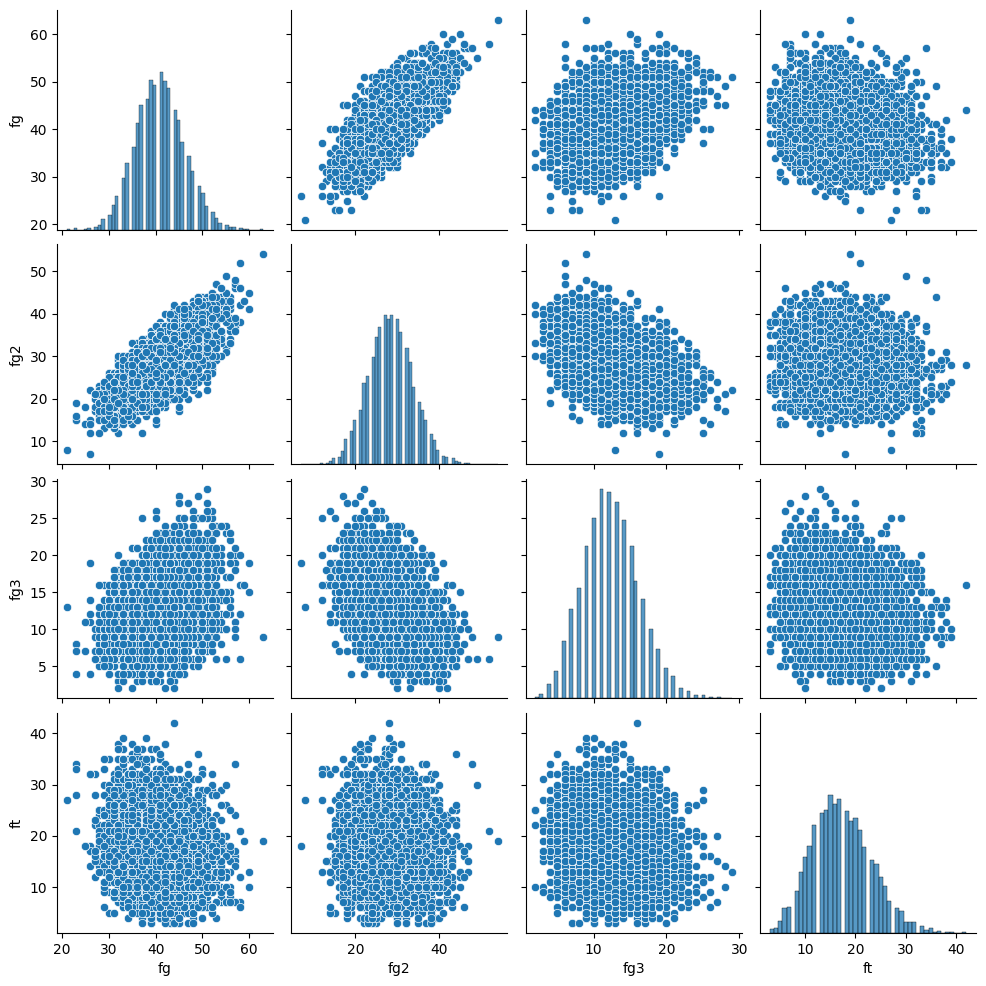

In [27]:
import seaborn as sns

sns.pairplot(team.game_data[value_vars_made])

As expected, we see from the chart above that there are strong correlations between fgs made and fg2 (since fg2 are used to calculate fg) and fg3 (however weaker correlation). 

The variables from the graph above we see are normally distributed.

In [28]:
params_group = {'id_vars': ['game_id', 'Team_Abbrev', 'Win'], 'value_vars': value_vars_made, 'var_name': 'shot_category'}
params_bx = {'y': 'value', 'x': 'shot_category', 'color': 'Win'}

In [29]:
# box plot for attempting

team.create_box_plot(data = team.game_data, params_group=params_group, params_bx=params_bx)

As expected, winning teams make more shots than losing teams. The difference however is very similar across all categories, and we see that teams still rely more on 2 point field goals than on 3 point field goals.

However witth the graph above we see that 3 point shots represent around 25% of total shots (fg3 are included in the fg metric), while 2 point field goals represent 75% of shots

To get a better indication of the style of play we can take a look at attempts, where we will understand more about a teams' playing style.

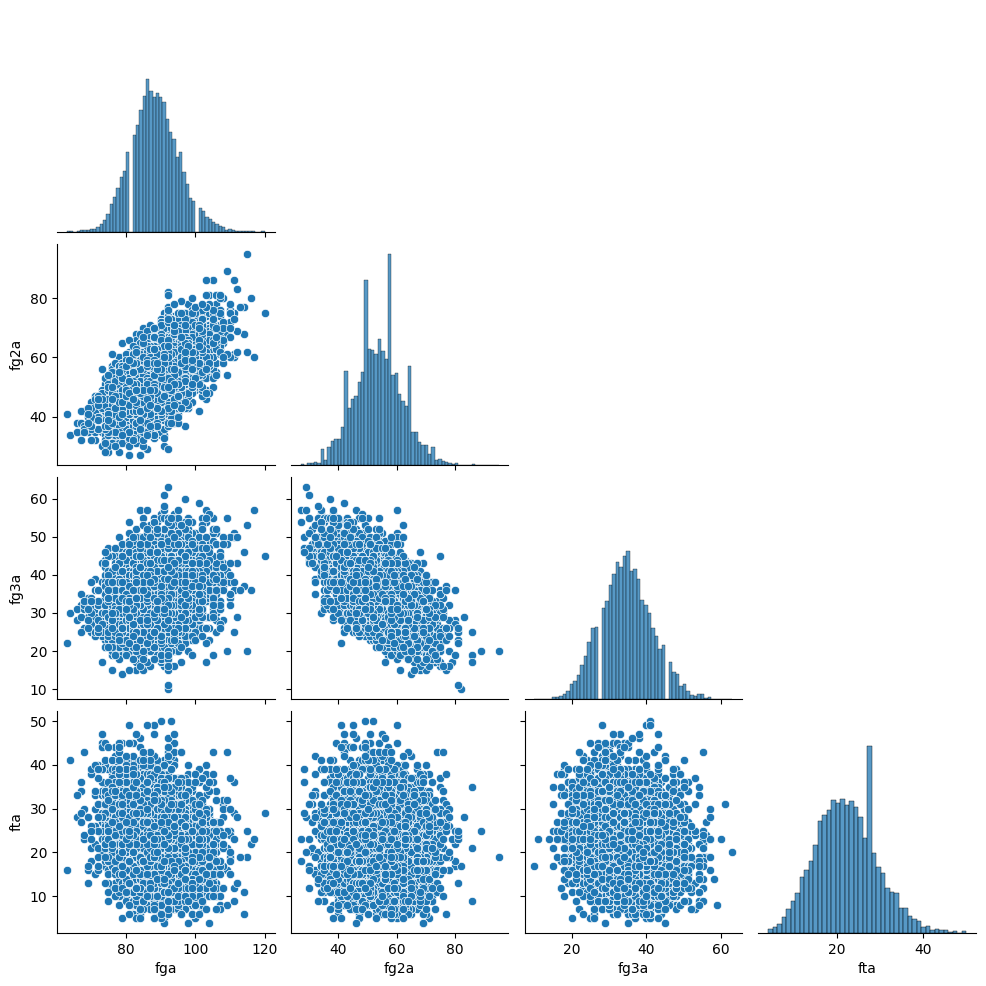

In [30]:
sns.pairplot(team.game_data[value_vars_att], corner = True)

In the charts above we see that most of the variables have a normal distribution and have none to moderate correlations.

fg3a to fg2a  are negatively correlated with each other. This makes mathematical sense, since everytime a 3 pointer is attempted, a team is foregoing a 2 point attempt

In [31]:
params_group = {'id_vars': ['game_id', 'Team_Abbrev', 'Win'], 'value_vars': value_vars_att, 'var_name': 'shot_category'}
params_bx = {'y': 'value', 'x': 'shot_category', 'color': 'Win'}

In [32]:
# box plot for attempting

team.create_box_plot(data = team.game_data, params_group = params_group, params_bx = params_bx)

From the boxplots above, there is no significant difference in the values of the studied variables between winning and losing teams. The chart above gives an indication that in terms of simple shot distribution (not taking into account distance from the basket), winning and losing teams seem to play a similar style.

There are only two slight differences:
* Outliers for fg2a are higher for losing teams
* The 3rd quartile threshold is higher for winning teams, indicating they may shoot more attempts

However interestingly enough, we dont see a big difference between fg3a between winning and losing teams. 

To further the analysis of shot distribution, we would need more detailed data in terms of the type of shot and the distance of the shot, since a 18ft 2 point shoot is not the same as 4ft 2 point shot

In [33]:
params_scatter = {'y': 'fg3a', 'color': 'Win'}
px.scatter(data_frame=team.game_data, **params_scatter)

The scater plot above provides more evidence that there does not seem to be a high difference in playing styles between winning and losing teams. If we would see a stark difference in the variable, we would see a clear separation between each set of points. However, in the chart above, both yellow and blue points are mixed with each other, indicating that there is not much of a difference in terms of 3 point field goals attempted.

In [34]:
params_scatter = {'y': 'fta', 'color': 'Win'}
px.scatter(data_frame=team.game_data, **params_scatter)

Very similar conclusion for free throw attempts. Free throws we see more of a difference, but very slight. We can reach a similar conclusion to the one reached for 3 point field goals

Lets analyze the differences between teams and their propensity to attempt 3 pointers

In [35]:
params_group = {'id_vars': ['game_id', 'Team_Abbrev', 'Win'], 'value_vars': ['fg3a'], 'var_name': 'shot_category'}
params_bx = {'y': 'value', 'x': 'Team_Abbrev'}

In [36]:
params_sort = {'by':'value', 'ascending':False}
team.create_box_plot(data = team.game_data, params_group=params_group, params_bx=params_bx, sort=True, params_sort=params_sort)

From the chart above we do see differences across teams. We see that all teams as a median attempt 30 3 pointers a game, however we see the Houston Rockets, Utah and Brookly rely heavily on 3 point field goals. Lets see how correlated 3 point attempts are with winning in the NBA standings.

In [37]:
season = td.TeamSeason(team.game_data)
season.get_season_stats()

In [38]:
season.season_data

Team_Abbrev     season  games  wins  loses
0          ATL  2019-2020     67    20     47
1          ATL  2020-2021     71    40     31
2          ATL  2021-2022     83    44     39
3          BOS  2019-2020     72    48     24
4          BOS  2020-2021     71    36     35
..         ...        ...    ...   ...    ...
85         UTA  2020-2021     71    51     20
86         UTA  2021-2022     83    50     33
87         WAS  2019-2020     72    25     47
88         WAS  2020-2021     71    33     38
89         WAS  2021-2022     85    37     48

[90 rows x 5 columns]

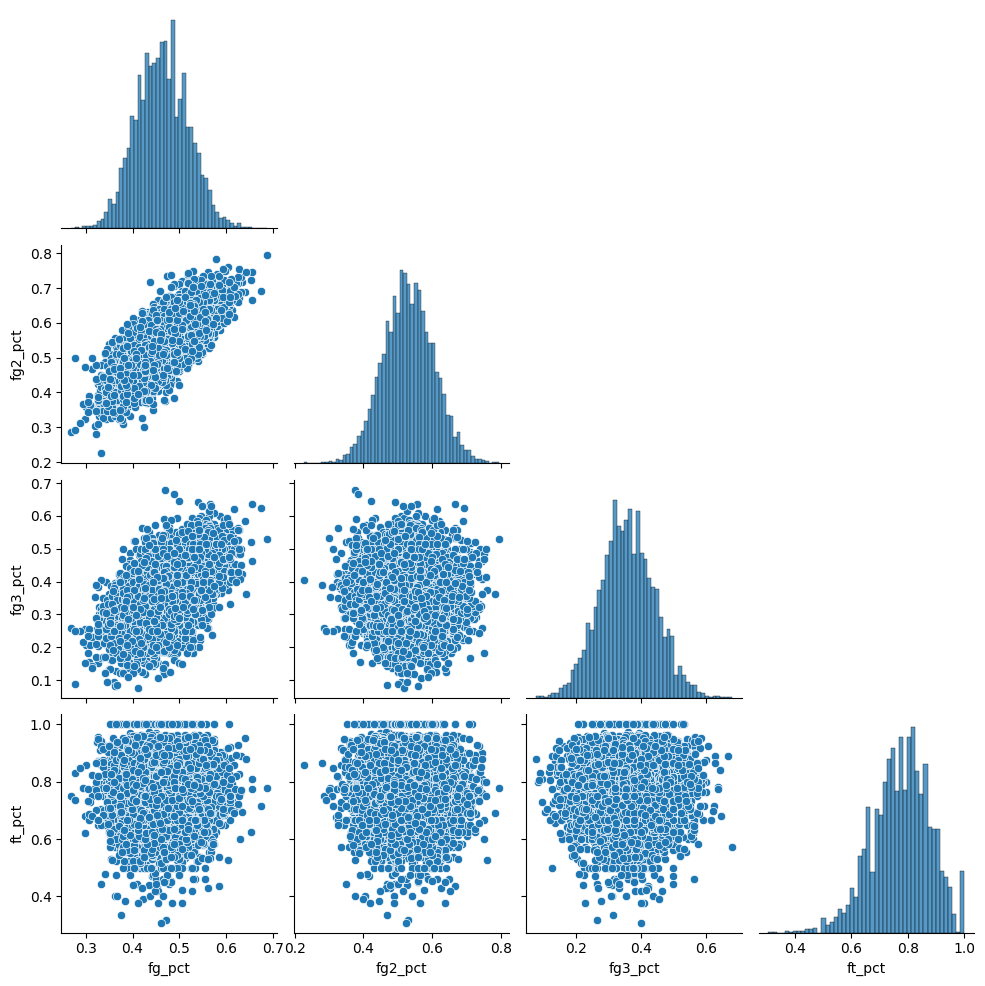

In [39]:
sns.pairplot(team.game_data[value_vars_pct], corner = True)

In [40]:
params_group = {'id_vars': ['game_id', 'Team_Abbrev', 'Win'], 'value_vars': value_vars_pct, 'var_name': 'shot_category'}
params_bx = {'y': 'value', 'x': 'shot_category', 'color': 'Win'}

In [41]:
# box plot for attempting

team.create_box_plot(data = team.game_data, params_group=params_group, params_bx=params_bx)

As expected, we see that in conversion there is a distinct difference between teams field goal percentaes across all variables. 

There is a slight difference between the conversion differential between winning and losing teams for fg3 vs fg2. The fg% for fg3 is ~60 basis points different between winning and losing teams, while for losing teams the difference in fg2 is 40 basis points. 

This may indicate that a fg3 percentage is going to be a predictor for winning and losing versus fg2 percentage.

From the analysis above, we see that in terms of simple shot distribution, there is no major difference between winning and losing teams. In the modern day NBA, it seems that all teams have adopted a playing style relying on 30 3pt field goal attempts, and no major differences in the conversion between winning and losing teams.

We do see that there is a stark difference between winning and losing teams in terms of conversion, however that is quite expected.

However in this analysis, we are analyzing the outcome of specific games. To analyze further the style of the best teams in the NBA, we could isolate the high ranking teams and analyze further theyre playing style.

## Other indicators for style of play

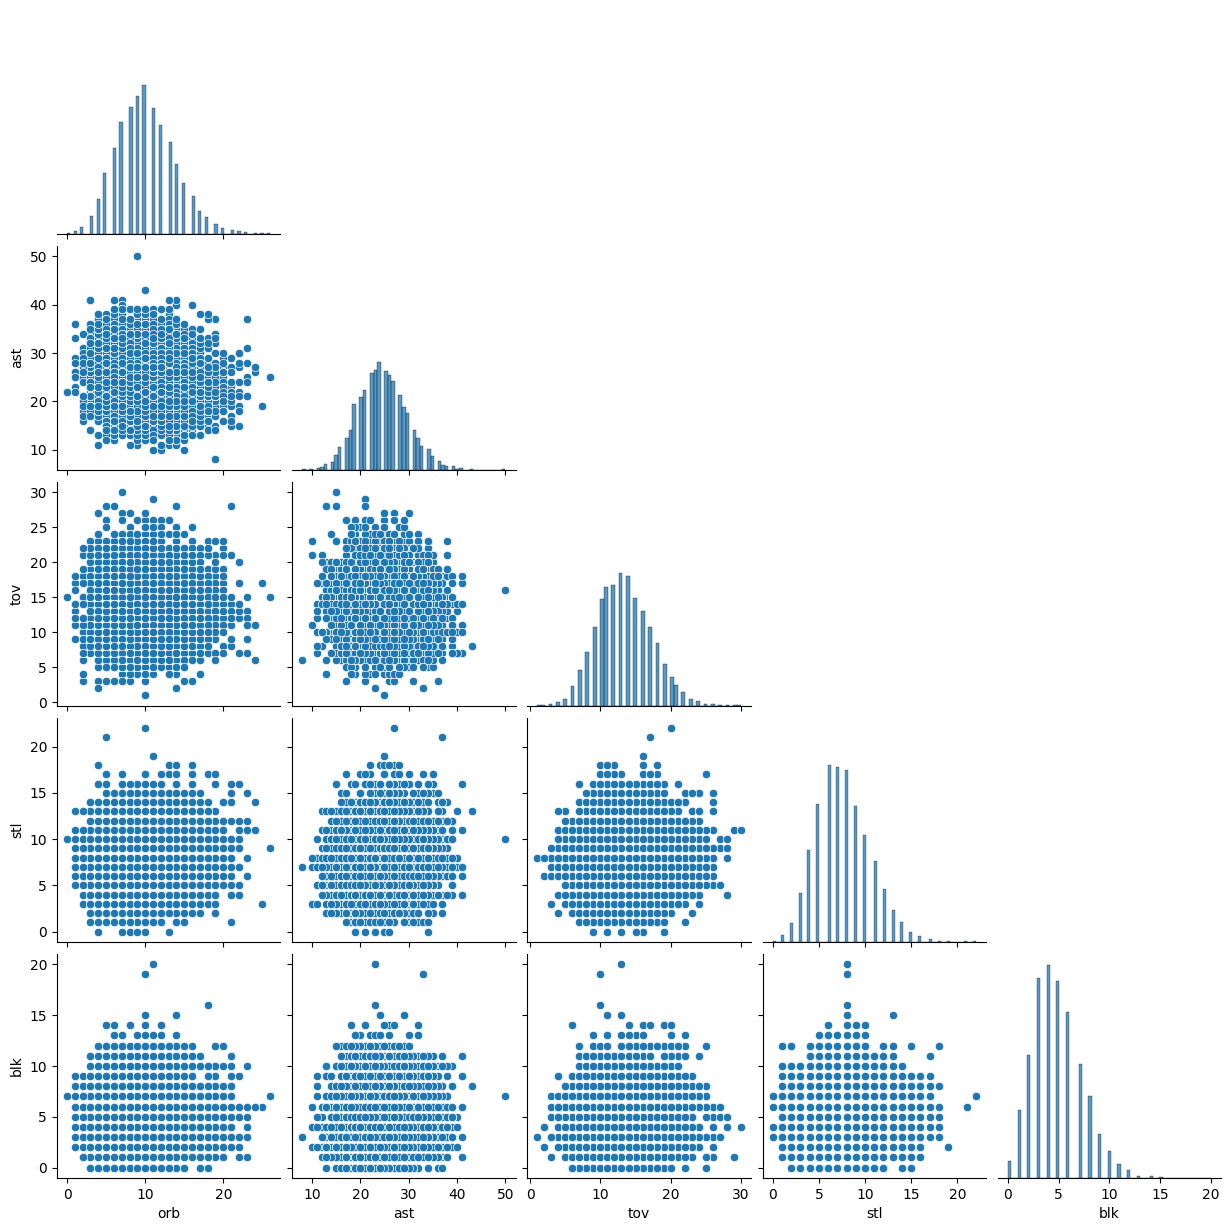

In [42]:
other_vars = ['orb', 'ast', 'tov', 'stl', 'blk']

sns.pairplot(team.game_data[other_vars], corner = True)

In [43]:
params_group = {'id_vars': ['game_id', 'Team_Abbrev', 'Win'], 'value_vars': other_vars, 'var_name': 'box_score_stat'}
params_bx = {'y': 'value', 'x': 'box_score_stat', 'color': 'Win'}

In [44]:
# box plot for attempting

team.create_box_plot(data = team.game_data, params_group=params_group, params_bx=params_bx)

The variables above give us a better indication of how winning teams play.

Offensive rebounds are traditionally seen as a stat that could turn any game and key in the playoffs. However statistically it can represent three things: 1) a team missed a lot of shots and there were a lot of opportunities for an offensive rebound, 2) the team outhustled the other team and got a lot of rebounds, 3) both. To analyze better offensive rebounding, we need to take a look at offensive rebound rate

Assists seem like the highest indicator for a winning team. The median is 3 points higher than for losing teams and the outlier distribution is higher than for losing teams. This supports conventional basketball wisdom, since assists are usually seen to lead to higher quality shots and lead to better shot conversions.

The difference of turnovers, steals and blocks between losing and winning teams also supports conventional wisdom, but less significant than steals

[[1.         0.62193609]
 [0.62193609 1.        ]]


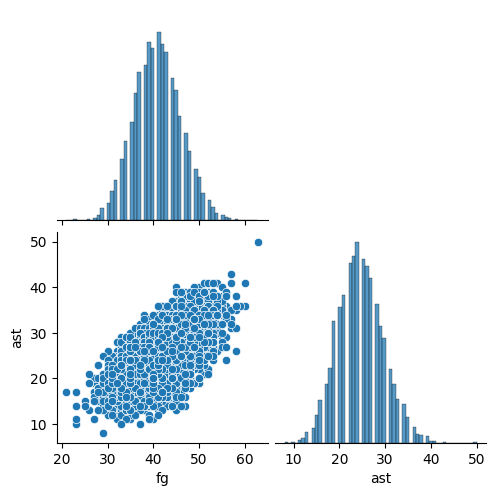

In [45]:
sns.pairplot(team.game_data[['fg', 'ast']], corner = True)

import numpy as np

print(np.corrcoef(x = team.game_data['fg'], y = team.game_data['ast']))

In [46]:
# calculate assist ratio

team.game_data['ast_ratio'] = team.get_assist_ratio(data = team.game_data, ast = 'ast', fga = 'fga', fta = 'fta', to = 'tov')

In [47]:
params_group = {'id_vars': ['game_id', 'Team_Abbrev', 'Win'], 'value_vars': ['ast_ratio'], 'var_name': 'assist_ratio'}
params_bx = {'y': 'value', 'x': 'assist_ratio', 'color': 'Win'}

In [48]:
team.create_box_plot(data = team.game_data, params_group=params_group, params_bx=params_bx)

So for winning teams we see a less pronounced difference between assists and winning, but we still see a significant difference between assist ratio and winning a game.

Despite the lower difference, this statistic is more robust since conceptually, is less dependent on the amount of made field goals (since assists)

[[1.         0.53201185]
 [0.53201185 1.        ]]


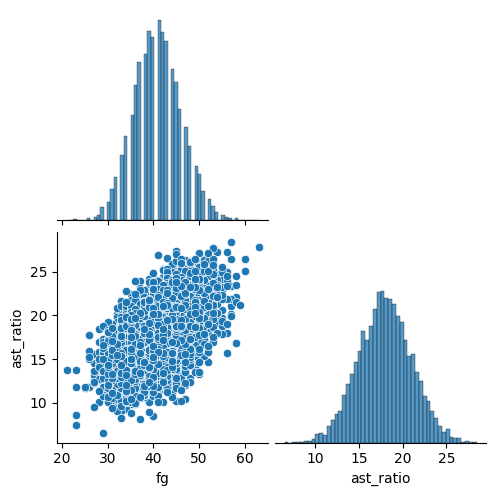

In [49]:
sns.pairplot(team.game_data[['fg', 'ast_ratio']], corner = True)

print(np.corrcoef(x = team.game_data['fg'], y = team.game_data['ast_ratio']))

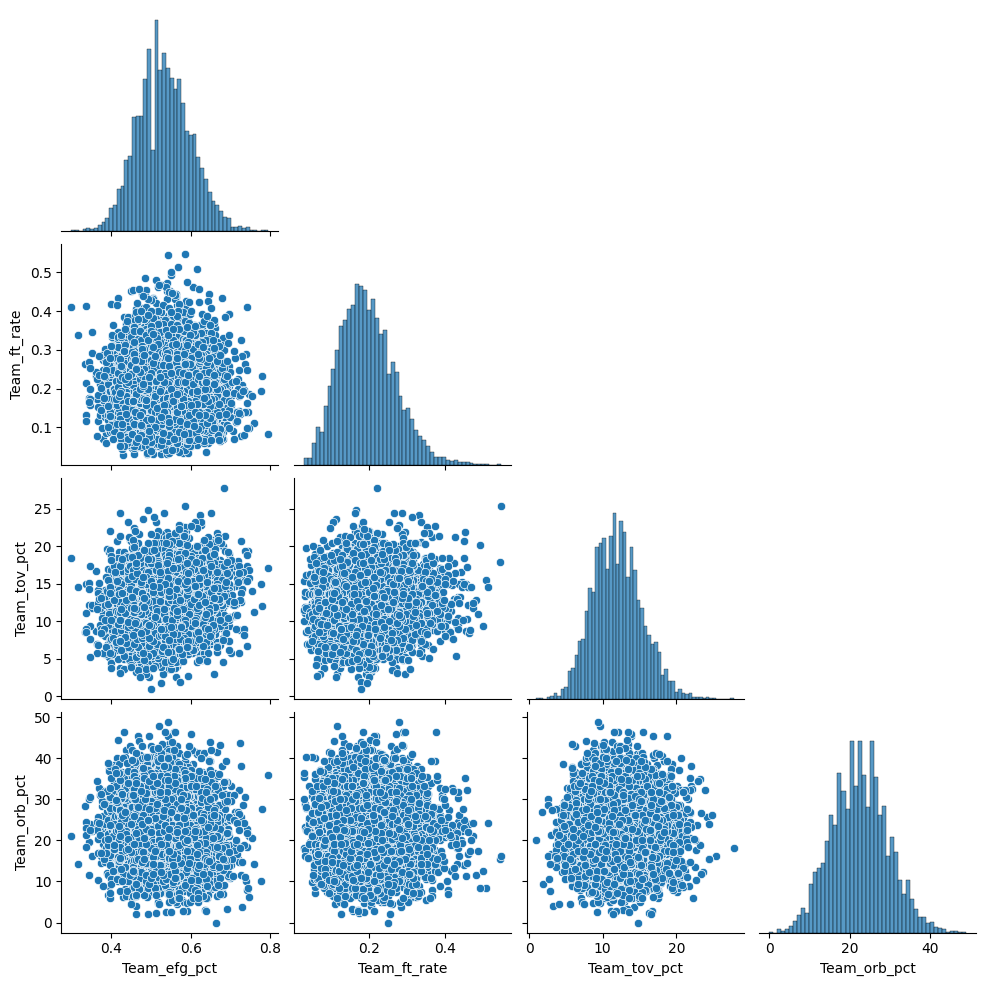

In [50]:
vars_pct =  ['Team_efg_pct', 'Team_ft_rate']
vars_rates = ['Team_tov_pct', 'Team_orb_pct']

sns.pairplot(team.game_data[vars_pct + vars_rates], corner = True)

In [51]:
params_group = {'id_vars': ['game_id', 'Team_Abbrev', 'Win'], 'value_vars': vars_pct, 'var_name': 'advanced_stats'}
params_bx = {'y': 'value', 'x': 'advanced_stats', 'color': 'Win'}

In [52]:
# box plot for attempting

team.create_box_plot(data = team.game_data, params_group=params_group, params_bx=params_bx)

In [53]:
scatter_params = {'y': 'Team_efg_pct', 'color': 'Win'}
px.scatter(data_frame=team.game_data, **scatter_params)

[[1.         0.64504381]
 [0.64504381 1.        ]]


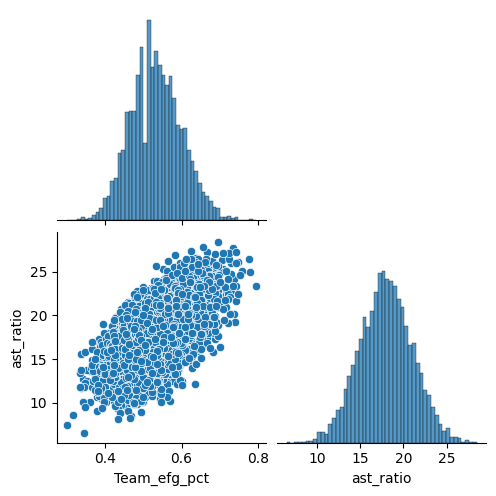

In [54]:
sns.pairplot(team.game_data[['Team_efg_pct', 'ast_ratio']], corner = True)

print(np.corrcoef(x = team.game_data['Team_efg_pct'], y = team.game_data['ast_ratio']))

The effective field goal percentage has been one of the strongest indicators to differentiate between winning and losing teams. Winning teams have a median higher by 60 basis points corresponding to losing teams. This is also indicates that 3 pointers do have 

Free throw rate we also see a significant difference, but less pronounced, by 20 basis points.

In [55]:
params_group = {'id_vars': ['game_id', 'Team_Abbrev', 'Win'], 'value_vars': vars_rates, 'var_name': 'advanced_stats'}
params_bx = {'y': 'value', 'x': 'advanced_stats', 'color': 'Win'}

In [56]:
# box plot for attempting

team.create_box_plot(data = team.game_data, params_group=params_group, params_bx=params_bx)

In the turnover pct and orb pct we also see a difference a slight difference in both variables corresponding to traditional basketball wisdom. Teams committing less turnovers tend to win the game, and teams with a higher offensive rebound percentage tend to win the games as well.

In [57]:
# save data for feature analysis
team.game_data.to_csv(f'./data/team_data.csv')